# AIAIART #3 - GANs and CLIP

In [1]:
#@title Setup and Imports (run this first)
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

from CLIP import clip # The clip model
from torchvision import transforms # Some useful image transforms
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library

# Intro


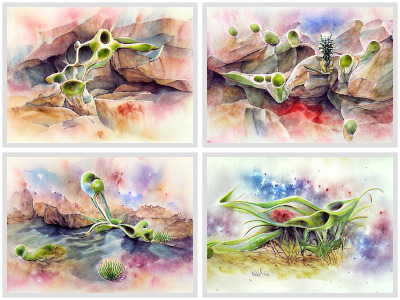

In [lesson 1](https://colab.research.google.com/drive/1pp8hS5C6RTMpOLBJMwnx3d7JjicqgJKx?usp=sharing) we met PyTorch. We saw how to create and manipulate tensors, and took advantage of the autograd system and built-in optimizers to do gradient descent. 

In [lesson 2](https://colab.research.google.com/drive/1Rk8cXMdad9ASIVI6avPyp5bl0qmeOu6S?usp=sharing) we dived into how neural networks are built, and how we can use them to our advantage. We also looked briefly at autoencoders and saw how we could optimize the inputs to a neural network that generates images, rather than just optimizing pizels directly. 

With this groundwork covered, we have everything we need to look at what many of you will assiciate with the 'State Of The Art' (SOTA) on AI art: Text-to-Image with a GAN + CLIP. The images above were generated using this approach, based on text descriptions like 'a watercolour botannical illustration of an alien plant near water'. For many, this application seems especially magical - and it is!

We'll look at the two main components individually and then spend the second half of the lesson making them work together, playing with ways to imprive the results, adding in some trippy transforms and generally having fun with these great tools.

# GANs - Theory

The motivation for GANs was the desire for a generative model that could generate plausible new images (or any kind of data for that matter) that look like they could have come from some domain or training set. In the bonus section of the previous notebook we saw how Variational Auto-Encoders learn how to encode an input into some latent representation and then decode it back into an output, and how the decoder part of an auto-encoder can be used to generate new images. 

GANs achieve a similar result but tend to peform far better than auto-encoder based systems at generating new, **novel** outputs. 

They do this by training two separate sub-networks, a generator network and a discriminator network. They are trained in parallel. The goal of the discriminator is to tell whether a given image is real (aka from the training data) or fake (aka generated by the generator model). The generator tries to create plausible outputs to fool the discriminator.


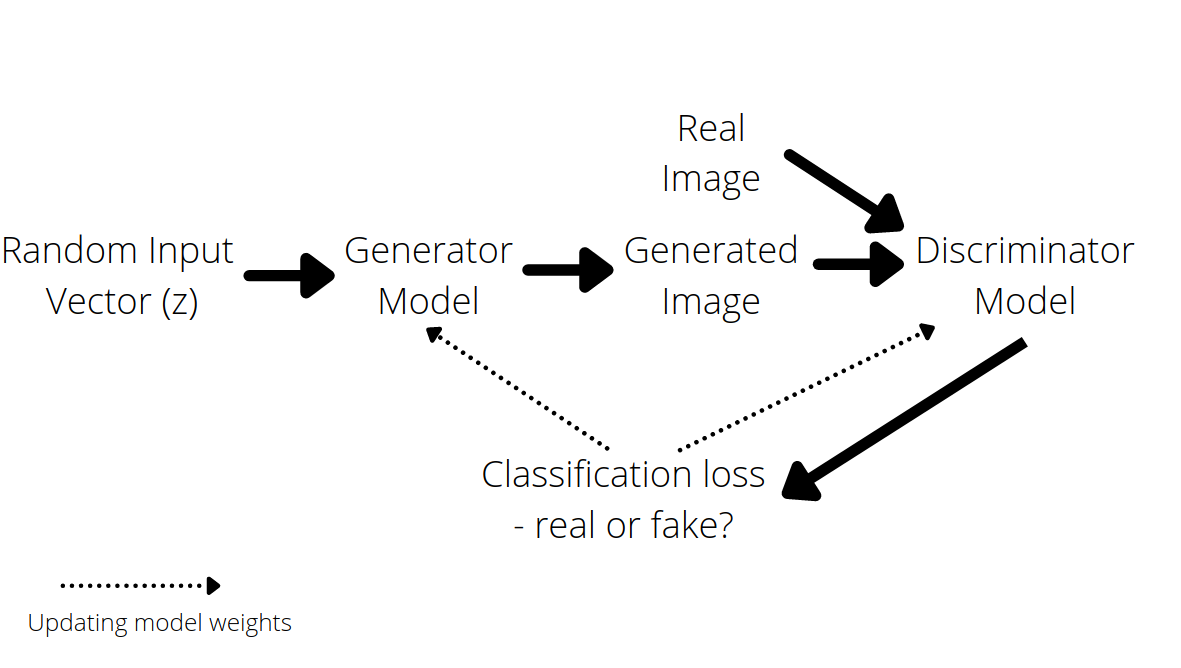

You can see an interactive demo of a simple GAN in the following cell:

In [ ]:
#@title GanLab
from IPython.display import HTML
HTML('<iframe width="1500" height="660" src="https://poloclub.github.io/ganlab/" allowfullscreen></iframe>')

A typical GAN training loop might look something like the following:

for batch in data:
  - generate a batch of fake images
  - feed both the fake images and the batch of training images into the discriminator
  - calculate the discriminator loss and update the discriminator weights to improve it's accuracy
  - update the weights of the generator to better fool the discriminator (i.e. increase the discriminator loss)

This core idea is very simple, and yet GAN training can fail in some unexpected ways. For example, a GAN that perfectly memorizes the training data can fool the discriminator perfectly, but might not be able to generate any new data. Even worse: it can get away with memorizing only a subset of the training data, a situation called 'mode collapse'. 

I've moved anything related to GAN training to a bonus section - for the main part of this notebook we'll instead jump straight from the theory covered above to a modern GAN (with a few extra tricks). 

# Using VQGAN

For today's demos we'll use a powerful architecture called VQGAN ('Vector-Quantized GAN') that combines transformers with the more traditional CNN components to train a very good generative model.

![vqgan im](https://compvis.github.io/taming-transformers/paper/teaser.png)

You can find more details here: https://compvis.github.io/taming-transformers/

If you look at the diagram above, you'll see that while there is the additional complexity of the codebook creation and the transformer, the core pieces still look something like the GAN architectures described before. There is a CNN Decoder that can go from a latent representation z to an output image, a CNN Discriminator that tries to distinguish real and fake images and an encoder that can take an existing image and map it to the internal representation. 

We'll use a pre-trained VQGAN model and test out encoding images, decoding random 'z' tensors to make new images and interpolating between different images in 'z-space'. There are many pre-trained models to choose from - the one we'll use (`vqgan_imagenet_f16_16384`) has been trained on Imagenet but as you'll see later this doesn't stop it from being able to generate very un-imagenet-like images!

First, let's get the model weights and some info that will help load this particular model:

In [2]:
# @title some setup and convenience functions

# Downloading the pre-trained VQGAN model weights:
print('Downloading ImageNet 16384 checkpoints')
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

# I like to save the weights to my drive so that I can do this instead:
# !cp 'drive/My Drive/vqgan_imagenet_f16_16384.yaml' vqgan_imagenet_f16_16384.yaml
# !cp 'drive/My Drive/vqgan_imagenet_f16_16384.ckpt' vqgan_imagenet_f16_16384.ckpt

print('Installing a few libraries')
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install einops                                       &> /dev/null
from omegaconf import OmegaConf
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
  d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
  indices = d.argmin(-1)
  x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
  return replace_grad(x_q, x)

def synth(z):
  z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
  return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(width, height):
  f = 2**(model.decoder.num_resolutions - 1)
  toksX, toksY = width // f, height // f
  n_toks = model.quantize.n_e
  one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
  z = one_hot @ model.quantize.embedding.weight
  z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
  return z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   692  100   692    0     0    538      0  0:00:01  0:00:01 --:--:--  135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  10.5M      0  0:01:28  0:01:28 --:--:-- 10.9M58M    0     0  9749k      0  0:01:38  0:00:16  0:01:22 10.9M
Installing a few libraries


In the setup section there are a few functions to make working with VQGAN easier. There is also code to download the pretrained model weights (you can find links to different pretrained versions in some of the popular VQGAN notebooks).

WIth that done, loading the model is simply:

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


8.19kB [00:00, 241kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


Let's encode an image and see the resulting z:

In [10]:
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" >> /dev/null
im = Image.open('cat.jpeg').convert('RGB').resize((256, 256))
im = torch.tensor(np.array(im)).permute(2, 0, 1)/255
im = im.unsqueeze(0).to(device) * 2 - 1 # The encoder expects inputs in the range (-1, 1)
z, *_ = model.encode(im)
print('Image shape:', im.shape)
print('Z shape:', z.shape)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58517  100 58517    0     0   485k      0 --:--:-- --:--:-- --:--:--  488k
Image shape: torch.Size([1, 3, 256, 256])
Z shape: torch.Size([1, 256, 16, 16])


In [6]:
# Exercise: Change the size of the image in the .resize() call. What happens to the shape of z?

Now we can re-construct the input image using the model's decoder. 

In [11]:
out = synth(z)
out.shape

torch.Size([1, 3, 256, 256])

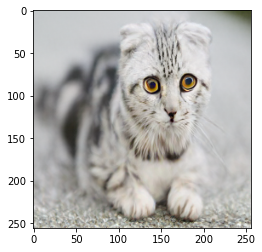

In [12]:
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

In [9]:
# Again, change the input shape. Does the size of the output image ever not match that of the input image?

Let's try generating an image by feeding in a random z to the decoder:

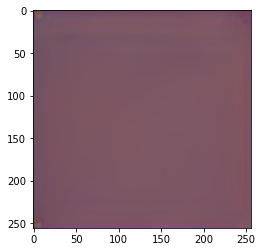

In [13]:
z = torch.rand(1, 256, 16, 16).to(device)
out = synth(z)
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

So, a little extra work is needed to get a z that looks like something the model expects based on its learned embeddings. I wrote a function to make life easier (see the hidden code above): 

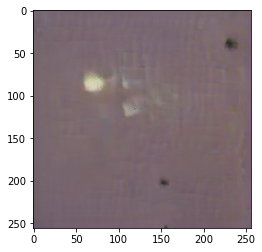

In [15]:
z = rand_z(256, 256)
out = synth(z)
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

Even with this, we don't ever get any nice-looking images. What's the deal? Refer to the paper - VQGAN is not designed to make pretty images from a random input (and I've been lying to you!). But it DOES learn a codebook and decoder that are capable of generating a very wide range of good-looking output images provided we 'guide' the output somehow. In the paper, they show how transformers can learn various tasks (using the compressed internal representations as items in a sequence) such as class-conditional generation, depth-to-image synthesis etc etc. 

We're going to use CLIP to steer things, as you'll see in the next section. Before then though, let's do one example of interpolating between different images by moving linearly between their latent representations:

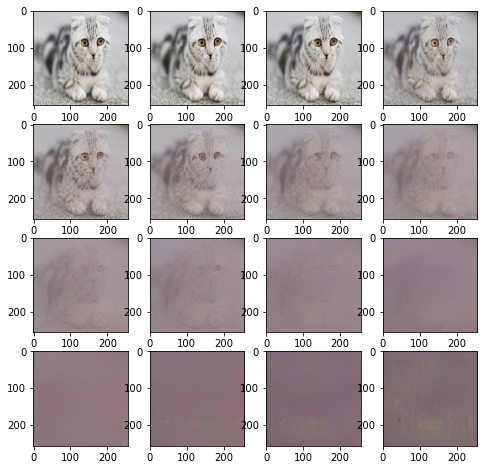

In [16]:
z1, *_ = model.encode(im) # The cat image from earlier
z2 = rand_z(256, 256)
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
  z_new = z1 + (z2-z1)*(i/16)
  out = synth(z_new)
  axs[i//4, i%4].imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

Interpolating between wildly different images tends to produce some weird intermediate images (as you'd expect). However, it can be useful when working with similar images (eg successive frames of a video) if you'd like to smooth the transition between them.

# CLIP

We met CLIP briefly in the first lesson, but now that we have a bit more experience under our belts let's take a deeper look at both the summary blog post (https://openai.com/blog/clip/) and the paper (https://arxiv.org/abs/2103.00020) to see if we can understand the internals. (See the video run-through for an exploration of these resources if you're not reading this during the live lesson).

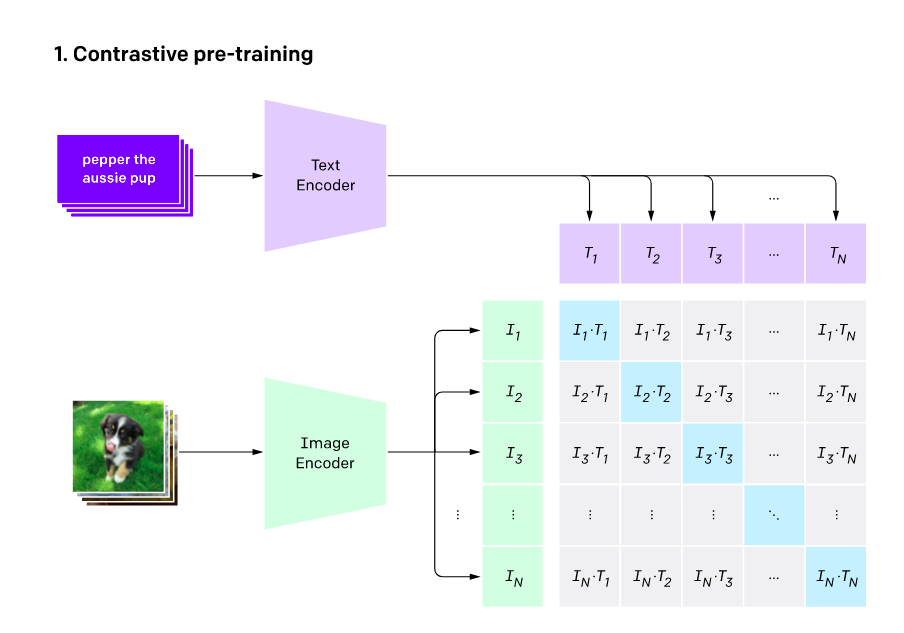

They train an image encoder and a text encoder simultaneously on a dataset
of 400 million (image, text) pairs collected from the internet. Images and text are both transformed into encodings that can be directly compared. 


From the paper, "*To do this, CLIP learns a multi-modal embedding space by jointly training an image encoder and text encoder to maximize the cosine similarity of the image and text embeddings of the N real pairs
in the batch while minimizing the cosine similarity of the
embeddings of the N2 − N incorrect pairings. We optimize a symmetric cross entropy loss over these similarity
scores*"

The OpenAI team actually trained several different image encoders. Some were based on the ResNet architecture, a fairly popular Convolutional Neural Network type. Others were based on something called a Vision Transformer. The text encoder is also a transformer model. We haven't covered transformer models, and they're a little out of scope for this course - for now we just need to know that they're great at modelling sequence data like text, and it turns out that by representing an image as a sequence of smaller image patches they're pretty good at dealing with images too.

Let's load up CLIP and encode some different inputs and then see what we can do with this.

In [17]:
# Load in one of the models from CLIP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
print(perceptor.visual.input_resolution) # 224px a side

224


In [18]:
# Embed some text
text_embed = perceptor.encode_text(clip.tokenize("A dog").to(device)).float()
text_embed.shape

torch.Size([1, 512])

In [19]:
# Create a random image
im = torch.rand(1, 3, 224, 224) # Does this work with different sizes?

# Create a transform - this will map the image data to the same range as that seen by CLIP during training
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])

# Embed the image
image_embed = perceptor.encode_image(normalize(im).to(device)).float()
image_embed.shape

torch.Size([1, 512])

If we can define a way to measure 'similarity' or 'distance' between representations, we can do things like compare an image with several labels and pick the best match, effectively creating a new classifier without any need for re-training ('zero-shot learning'):

In [21]:
# Load in the cat image
im = Image.open('cat.jpeg').convert('RGB').resize((224, 224)) 
im = torch.tensor(np.array(im)).permute(2, 0, 1)/255
im = im.unsqueeze(0).to(device)

# Embed the image
image_embed = perceptor.encode_image(normalize(im).to(device)).float()

# Create a measure of similarity
similarity = torch.nn.CosineSimilarity()

# Specify some labels
labels = ['A dog', 'A cat', 'A sealion']

# Run through the labels and see which is the best match:
losses = []
for label in labels:
  text_embed = perceptor.encode_text(clip.tokenize(label).to(device)).float()
  loss = 1 - similarity(image_embed, text_embed).item() # Higher similarity -> lower loss
  losses.append(loss)
  print(label+':', loss)

print('Prediction:', labels[np.argmin(losses)])


A dog: 0.783756747841835
A cat: 0.7212164402008057
A sealion: 0.8002980053424835
Prediction: A cat


DISCUSS: Why 1-similarity? Re-write the code above without the word 'loss' in a way that makes sense.

As an alternative to cosine similarity, we can re-use the Great-Circle-Distance-Squared loss we defined in lesson 1. Here a lower number means a closer match:

In [23]:
def clip_loss(im_embed, text_embed):
  im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
  text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

clip_loss(image_embed, text_embed)

tensor(0.9381, device='cuda:0')

# GANS + CLIP

The time has come to combine both of these ideas! We'll optimize the z fed into the GANs decoder by measuring a loss using CLIP:

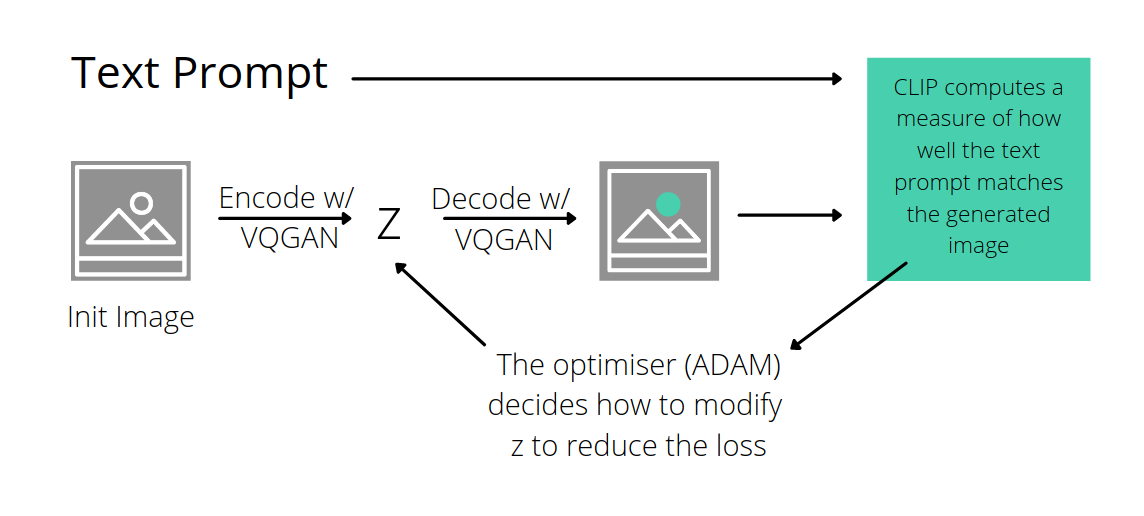

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.7602980136871338
25 0.7505550980567932
50 0.7365609407424927
75 0.7135725021362305
100 0.7337688207626343
125 0.6726714968681335
150 0.7547804117202759
175 0.6562101244926453
200 0.7069562673568726
225 0.7127153873443604
250 0.694171667098999
275 0.738845705986023
300 0.6715511083602905
325 0.6549503803253174
350 0.6534894704818726
375 0.6475138664245605
400 0.6618480682373047
425 0.6485224962234497
450 0.6803261637687683
475 0.6806176900863647
500 0.6451850533485413
525 0.655567467212677
550 0.7245889902114868
575 0.6621652841567993
600 0.7216889262199402
625 0.6418201327323914
650 0.7187590599060059
675 0.6545296907424927
700 0.6392534375190735
725 0.6469857692718506
750 0.6712918281555176
775 0.6461671590805054
800 0.640059232711792
825 0.6352410316467285
850 0.6421743631362915
875 0.7008413076400757
900 0.6481103897094727
925 0.6499826908111572
950 0.6730082631111145
975 0.6517283916473389


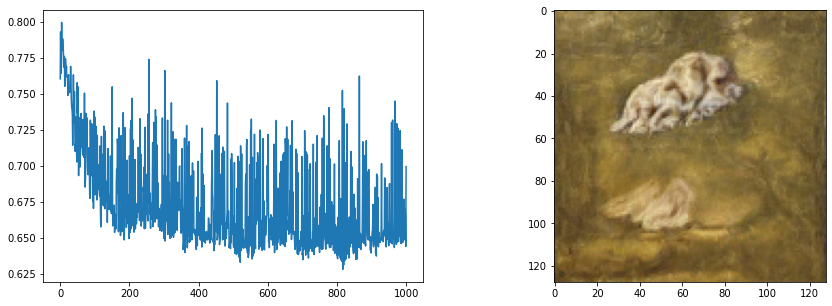

In [32]:
# Some text target
text_embed = perceptor.encode_text(clip.tokenize("A painting of a dog").to(device)).float()

# Starting z for image size 128x128
z = rand_z(128, 128) 
z.requires_grad=True

# A transform to map the generated image to the size expected by CLIP
crop = transforms.RandomResizedCrop(224)

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=0.1, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

for i in tqdm(range(1000)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss
  image_embed = perceptor.encode_image(crop(normalize(output)).to(device)).float()
  loss = 1- similarity(image_embed, text_embed) # torch.mean(output) #clip_loss(output, text_embed)
  # 相似度越高越好，因此loss需要是反过来~
  
  # Store the loss for later
  if i % 25 == 0:
    print(i, loss.detach().item())
  losses.append(loss.detach().item())

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(losses)
axs[1].imshow(synth(z).cpu().squeeze().detach().permute(1, 2, 0))

You could run the above for longer but before we spend too much time let's add a few final tweaks:
- Adding transforms and running several differently-transformed versions of the generated image through CLIP rather than just doing one image per iteration.
- Saving the intermediate images to a folder for later viewing
- A continually-updated display of the loss curve and current image
- Some form fields for prompts and parameters
- `clip_loss` as opposed to 1 - cosine similarity as used above

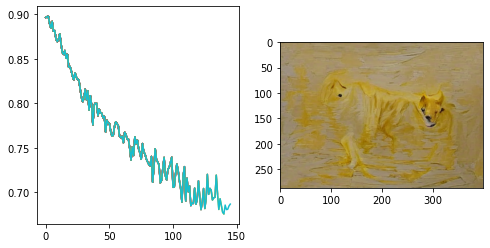

In [36]:
prompt_text = "A painting of a yellow dog " #@param
width = 400 #@param
height = 300 #@param
lr = 0.1 #@param
n_iter = 150 #@param
crops_per_iteration = 8 #@param

# The transforms to get variations of our image
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# The z we'll be optimizing
z = rand_z(width, height)
z.requires_grad=True

# The text target
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

# A folder to save results
!rm -r steps
!mkdir steps


# Display for showing progress
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
p = display(fig, display_id=True)

# The optimization loop:
for i in tqdm(range(n_iter)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss across several different random crops/transforms
  loss = 0
  for _ in range(crops_per_iteration):
    image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
    loss += clip_loss(image_embed, text_embed)/crops_per_iteration

  # Store loss
  losses.append(loss.detach().item())

  # Save image
  im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
  Image.fromarray(im_arr).save(f'steps/{i:04}.jpeg')

  # Update plots 
  if i % 5 == 0: # Saving time
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

ipd.clear_output()

# Let's talk tips

- The initialization has a big impact on the final result. Try creating your own init images with some basic structure
- Prompt engineering is a thing. Check https://imgur.com/a/SnSIQRu to see how adding certain keywords to different prompts can make a huge difference
- Run lots and pick the best!

## Exercises:
- Add some more transforms (see torchvision docs)
- Implement multiple text prompts
- Make it easy to specify an init image
- Implement image prompts
- Get rid of that for loop and handle multiple crops by combining multiple copies of the GAN output into a batch before applying the transforms
- Experiment with adding a style or content loss with reference to lesson 2 in combination with the CLIP loss


In [20]:
#@title Show Video
!ffmpeg -v 0 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progress_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

You can download the video and specific output frames from the files pane on the left. What can you make?

# Other Implementations

The example(s) above are illustrative, and I've tried to keep them simple. That said, they should put you in a position to understand the most commonly used notebooks such as this one (https://github.com/justin-bennington/S2ML-Art-Generator/blob/main/S2_VQGAN%2BCLIP_Classic.ipynb) based on the work by @Rivershavewings (from whom I've borrowed some code) which popularised this approach.

Let's take a look at it and see where it differs and what we can do with it.

# GAN Training

GAN training, as mentioned, can be difficult in practice. I tried for a while to find a simple way to make and train a GAN from scratch in a way that would fit within this lesson, without much luck. 

Here's a tutorial that might serve as a starting point for anyone curious to try this out: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html 

You can also see some more in-depth material here: https://deeplearning.neuromatch.io/tutorials/W2D5_GenerativeModels/student/W2D5_Tutorial2.html

Some info on typical GAN failure modes: https://youtube.com/watch?v=fmU2UM_QzLo

# Class-Conditional GANs

There are a few methods that have been introduced that can give more control over the outputs of a GAN. One popular method is to feed some additional information to the network, such as an image label (y) - this can be a number (such as the rotation of a face) but is most commonly a class label. For example, BIGGAN was trained on Imagenet which has 1000 different image classes.

By taking the class into account the generator can sample from the distribution of outputs associated with that class rather than trying to learn a single distribution that covers all images. 

BigGAN + CLIP pre-dates VQGAN+CLIP - see https://github.com/lucidrains/big-sleep for an easy-to-use implementation.

Here, we'll load a pre-trained BIGGAN model and generate some images in specific classes (as well as messing about with interpolating between them).


In [38]:
!pip install pytorch-pretrained-biggan --quiet

In [39]:
!pip install --upgrade urllib3 # Might be needed to fix a version clash

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/ec/03/062e6444ce4baf1eac17a6a0ebfe36bb1ad05e1df0e20b110de59c278498/urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
academictorrents 2.3.3 requires future==0.16.0, but you have future 0.18.2 which is incompatible.


In [40]:
from pytorch_pretrained_biggan import BigGAN
from pytorch_pretrained_biggan import one_hot_from_names
from pytorch_pretrained_biggan import truncated_noise_sample

import nltk
nltk.download('wordnet')

biggan_128 = BigGAN.from_pretrained('biggan-deep-128')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/chenweifeng/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
100%|██████████| 630/630 [00:00<00:00, 528165.40B/s]


In [ ]:
# print(biggan_128)

We need a way to encode the class (one of 1000 ImageNet classes) into something that can be fed to the model. This is done for us by the `one_hot_from_names` function:

In [41]:
one_hot_from_names('German shepherd').shape

(1, 1000)

In [42]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

If we want to generate an image that looks like it belongs in a specific class, we encode the class with the function above and then create a noise vector (effectively a random z) to feed into the model alongside the class vector. To keep the images looking sensible, we can **truncate** the noise vector - play with the truncation value and see what effect this has.



In [44]:
# @title generate_biggan_samples function
def create_class_noise_vectors(class_str, trunc, num_samples):
  class_vector = one_hot_from_names([class_str]*num_samples, batch_size=num_samples)
  noise_vector = truncated_noise_sample(truncation=trunc, batch_size=num_samples)
  return class_vector, noise_vector

# Generate samples from BigGAN
def generate_biggan_samples(model, class_vector, noise_vector, device,
                            truncation=0.4):
  # Convert to tensor
  noise_vector = torch.from_numpy(noise_vector)
  class_vector = torch.from_numpy(class_vector)

  # Move to GPU
  noise_vector = noise_vector.to(device)
  class_vector = class_vector.to(device)
  model.to(device)

  # Generate an image
  with torch.no_grad():
      output = model(noise_vector, class_vector, truncation)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer, resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1] range.
  # Clipping is only in case of numerical instability problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)
  output = output

  # Make grid and show generated samples
  output_grid = torchvision.utils.make_grid(output,
                                            nrow=min(4, output.shape[0]),
                                            padding=5)
  plt.imshow(output_grid.permute(1, 2, 0))

  return output_grid

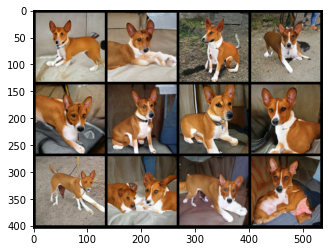

In [50]:
import torchvision
from matplotlib import pyplot as plt
CLASS =  'dog'
TRUNCATION = 0.4
NUM_SAMPLES = 12
class_vector, noise_vector = create_class_noise_vectors(CLASS, TRUNCATION,
                                                          NUM_SAMPLES)
samples_grid = generate_biggan_samples(biggan_128, class_vector, noise_vector,
                                        device, TRUNCATION)
torchvision.utils.save_image(samples_grid, 'samples.png')

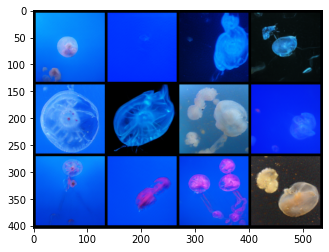

In [51]:
CLASS = 'Jellyfish'
TRUNCATION = 1
NUM_SAMPLES = 12
class_vector, noise_vector = create_class_noise_vectors(CLASS, TRUNCATION,
                                                          NUM_SAMPLES)
samples_grid = generate_biggan_samples(biggan_128, class_vector, noise_vector,
                                        device, TRUNCATION)
torchvision.utils.save_image(samples_grid, 'samples.png')

Here let's scale the noise vector to make it further and further from the center of the class:

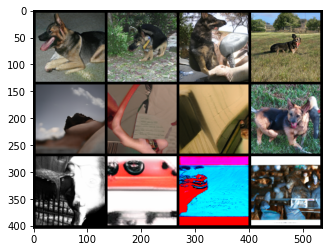

In [54]:
CLASS = 'German shepherd'
TRUNCATION = 1
NUM_SAMPLES = 12
class_vector, noise_vector = create_class_noise_vectors(CLASS, TRUNCATION,
                                                          NUM_SAMPLES)
noise_vector[:4,:] *= 1 # First row 
noise_vector[4:8,:] *= 2 # Second row 
noise_vector[8:,:] *= 3 # Third row 
samples_grid = generate_biggan_samples(biggan_128, class_vector, noise_vector,
                                        device, TRUNCATION)
torchvision.utils.save_image(samples_grid, 'samples.png')